# Recording Sound

Run to record.

Press 'q' key to stop recording.

It will save it to a wav file in the working directory.

In [21]:
import pyaudio
import wave
import keyboard

FORMAT = pyaudio.paInt16
CHANNELS = 2
RATE = 44100
CHUNK = 1024
WAVE_OUTPUT_FILENAME = "file2.wav"
 
audio = pyaudio.PyAudio()
 
# start Recording
stream = audio.open(format=FORMAT, channels=CHANNELS,
                rate=RATE, input=True,
                frames_per_buffer=CHUNK)
print("Recording...")
frames = []
    
while True:  # making a loop
    try:  # used try so that if user pressed other than the given key error will not be shown
        data = stream.read(CHUNK)
        frames.append(data)
        if keyboard.is_pressed('q'):  # if key 'q' is pressed 
            print('You Pressed A Key!')
            break  # finishing the loop
        else:
            pass
    except:
        break 
        
print("Finished Recording")

stream.stop_stream()
stream.close()
audio.terminate()
 
waveFile = wave.open(WAVE_OUTPUT_FILENAME, 'wb')
waveFile.setnchannels(CHANNELS)
waveFile.setsampwidth(audio.get_sample_size(FORMAT))
waveFile.setframerate(RATE)
waveFile.writeframes(b''.join(frames))
waveFile.close()

Recording...
You Pressed A Key!
Finished Recording


# Speaker Diarization 

This algorithm allows us to know who is speaking in a conversation.

In [115]:
import pandas as pd
import numpy as np
from pydub import AudioSegment
from pyAudioAnalysis import audioBasicIO
from pyAudioAnalysis import audioFeatureExtraction
from pyAudioAnalysis import audioSegmentation
from pyAudioAnalysis import audioTrainTest as aT
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure


# Obtain segments that are deemed to be silent.
def getSilenceSegments(ls):
    silenceSegments = []
    previous = 0
    for segment in ls:
        silenceSegments.append([previous, segment[0]])
        previous = segment[1]
    return silenceSegments

# Classifies audio into 2 speakers + plot functionality
def speakerDiarization(filename, plot = False):
    speakers = audioSegmentation.speakerDiarization(filename, 2, plot_res=False)
    speakers[speakers == 0] = -1
        
    dataframe = pd.DataFrame(speakers, columns=['category'])
    dataframe["seconds"] = np.linspace(0,dataframe.shape[0]/5,dataframe.shape[0])
    
    print("Speaker Diarization: Complete")
    
    [fs, x] = audioBasicIO.readAudioFile(filename)
    segments = audioSegmentation.silenceRemoval(x, fs, 0.020, 0.020, smoothWindow = 1, weight = 0.3, plot = True)
    segments = getSilenceSegments(segments)
    
    for silence in segments:
        dataframe["category"][dataframe["seconds"].between(silence[0], silence[1])] = 0
    
    print("Silence Detection: Complete")
        
    if plot == True:
        generatePlot(dataframe)
    return dataframe

# Plot functionality for speakerDiarization
def generatePlot(dataframe):
    figure(num=None, figsize=(5, 3), dpi=80, facecolor='w', edgecolor='k')
    plt.style.use('ggplot')
    x = dataframe["seconds"]
    plt.xticks(np.arange(min(x), max(x)+1, 20.0))
    plt.xticks(rotation=90)
    plt.yticks([-1, 0, 1])
    plt.xlabel("Seconds")
    plt.ylabel("Speakers")
    plt.title("Speaker Diarization")
    plt.plot(dataframe["seconds"], dataframe["category"])
    plt.show()
    
#test = speakerDiarization("Robin4.wav", plot = True)

# Event Classifcation

0 - Filler World  
1 - Laughter  
2 - Speech  
3 - Silence

Speaker Diarization: Complete


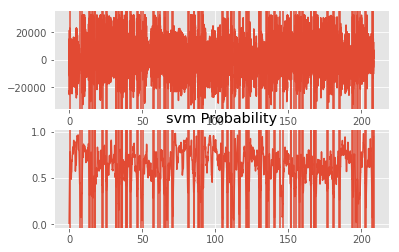

Silence Detection: Complete


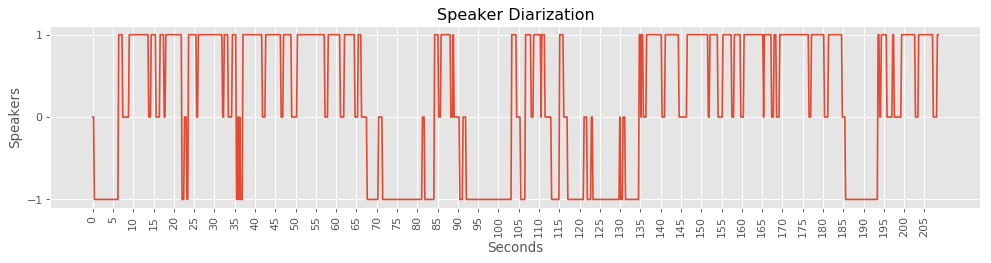

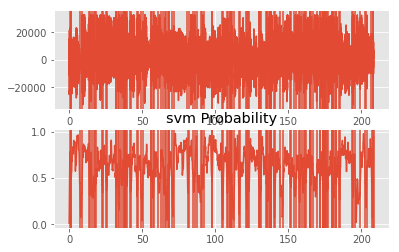

Time (Seconds):  0 0.3 Speaker:  0 Classification:  3 Probability:  0.9
Time (Seconds):  0.3 1.3 Speaker:  -1 Classification:  2.0 Probability:  1.0
Time (Seconds):  1.3 1.4 Speaker:  -1 Classification:  0.0 Probability:  0.84
Time (Seconds):  1.4 7.1 Speaker:  -1 Classification:  2.0 Probability:  1.0
Time (Seconds):  7.1 8.9 Speaker:  1 Classification:  1.0 Probability:  0.81
Time (Seconds):  8.9 13.7 Speaker:  1 Classification:  2.0 Probability:  0.98
Time (Seconds):  13.7 14.5 Speaker:  0 Classification:  3 Probability:  0.58
Time (Seconds):  14.5 15.5 Speaker:  1 Classification:  2.0 Probability:  0.98
Time (Seconds):  15.5 16.7 Speaker:  0 Classification:  3 Probability:  0.98
Time (Seconds):  16.7 17.4 Speaker:  1 Classification:  2.0 Probability:  0.81
Time (Seconds):  17.4 18.4 Speaker:  1 Classification:  0.0 Probability:  0.68
Time (Seconds):  18.4 22.4 Speaker:  1 Classification:  2.0 Probability:  0.98
Time (Seconds):  22.4 23.2 Speaker:  -1 Classification:  2.0 Probabilit

Time (Seconds):  169.4 171.6 Speaker:  1 Classification:  2.0 Probability:  1.0
Time (Seconds):  171.6 171.8 Speaker:  1 Classification:  0.0 Probability:  0.98
Time (Seconds):  171.8 173.4 Speaker:  1 Classification:  2.0 Probability:  1.0
Time (Seconds):  173.4 173.5 Speaker:  1 Classification:  0.0 Probability:  0.9
Time (Seconds):  173.5 173.7 Speaker:  1 Classification:  0.0 Probability:  0.77
Time (Seconds):  173.7 173.8 Speaker:  1 Classification:  0.0 Probability:  0.9
Time (Seconds):  173.8 174.8 Speaker:  1 Classification:  2.0 Probability:  0.99
Time (Seconds):  174.8 174.9 Speaker:  1 Classification:  0.0 Probability:  0.98
Time (Seconds):  174.9 175.4 Speaker:  1 Classification:  1.0 Probability:  0.73
Time (Seconds):  175.4 175.5 Speaker:  1 Classification:  0.0 Probability:  0.87
Time (Seconds):  175.5 176.5 Speaker:  1 Classification:  2.0 Probability:  0.86
Time (Seconds):  176.5 177.2 Speaker:  0 Classification:  3 Probability:  0.92
Time (Seconds):  177.2 179.8 Speak

In [57]:
# This function filters segments that's greater than 0.2 seconds.
def filterLength(segments):
    ls = []
    for segment in segments:
        if segment[1] - segment[0] > 0.2:
            ls.append(segment)
    return ls

# Input: filename of an audio file
# Output: Speaker Diarization Plot and returns a dataframe that holds information on speaker ID, segments, classifcation, and probability

def phoneAnalyzer(filename):
    #Obtain raw signal values from the audio file
    [fs, x] = audioBasicIO.readAudioFile(filename)
    
    # Convert stereo to mono since it's a wav file
    x = audioBasicIO.stereo2mono(x)
    
    # Obtain a dataframe on the speakers at each time step
    dataframe = speakerDiarization(filename, plot = True)  
    
    # Obtain segments of time that are non-silent.
    segments = audioSegmentation.silenceRemoval(x, fs, 0.020, 0.020, smoothWindow = 1, weight = 0.4, plot = True)
    segments = filterLength(segments)
    
    # Obtain segments of both silent and non-silent, sort it chronologically
    segments = sorted(segments + getSilenceSegments(segments), key=lambda x: x[0])
    
    startTime = []
    endTime = []
    speaker = []
    classification = []
    
    # Iterate through segments (Both silent and non-silent) obtained by silenceRemoval
    for segment in segments:
        
        # The portion of the raw data that is within the segment
        windowSlice = x[int(fs * segment[0]):int(fs * segment[1])]
        
        mt_win = 0.2
        mt_step = 0.2
        st_win = aT.shortTermWindow # 0.05
        st_step = aT.shortTermStep # 0.05
        
        # Load the trained SVM model
        [classifier, MEAN, STD, classNames, mt_win, mt_step, st_win, st_step, compute_beat] = aT.load_model("svm")
        
        # Obtain the midterm feature 
        [mt_term_feats, st_features, _] = audioFeatureExtraction.mtFeatureExtraction(windowSlice, fs, round(mt_win * fs), round(mt_step * fs), round(fs * st_win), round(fs * st_step))
        
        # Long-term averaging 
        mt_term_feats = mt_term_feats.mean(axis=1) 
        
        # Normalizing by having a mean of 0 and a standard deviation of 1
        curFV = (mt_term_feats - MEAN) / STD
        
        # Predict the segment
        R = classifier.predict(curFV.reshape(1,-1))[0]
        P = classifier.predict_proba(curFV.reshape(1,-1))[0]

        speakerID = int(dataframe[dataframe["seconds"] > segment[0]].iloc[0,0])
        
        # If silent, classify it as silence
        if speakerID == 0:
            R = 3
            
        print("Time (Seconds): ", round(segment[0], 1), round(segment[1], 1), "Speaker: ", speakerID, "Classification: ", R, "Probability: ", round(max(P), 2))
        
        startTime.append(round(segment[0], 1))
        endTime.append(round(segment[1], 1))
        speaker.append(speakerID)
        classification.append(R)
    
    # Construct a dataframe 
    data = pd.DataFrame({'Start Time': startTime, 'End Time': endTime, 'Speaker': speaker, 'Classification': classification})
    
    # Include Duration as another column
    data['Duration'] = data['End Time'] - data['Start Time']
    
    #Reordering the columns
    data = data[["Speaker", "Start Time", "End Time", "Duration", "Classification"]]
    
    return data

data = phoneAnalyzer("Sinclair.wav")

# Evaluating Speaker Classification

0 - Wrong  
1 - Correct

In [110]:
speakerTruth = [0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1,
               0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0,
               1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
               0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 
               1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 
                1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1,
               1, 1, 1, 1, 1, 1, 1, 1, 1]

classifcationTruth = [0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1,
                     1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1,
                     1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
                     1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1,
                     1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1,
                     1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1,
                     1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0]

print(len(speakerTruth))
print(len(classifcationTruth))

x = data

x["Speaker Truth"] = speakerTruth
x["Classification Truth"] = classifcationTruth
x

134
134


,Speaker,Start Time,End Time,Duration,Classification,Speaker Truth,Classification Truth
0,0,0.0,0.3,0.3,3.0,0,0
1,-1,0.3,1.3,1.0,2.0,1,1
2,-1,1.3,1.4,0.1,0.0,1,1
3,-1,1.4,7.1,5.7,2.0,1,1
4,1,7.1,8.9,1.8,1.0,1,0
5,1,8.9,13.7,4.8,2.0,1,1
6,0,13.7,14.5,0.8,3.0,0,1
7,1,14.5,15.5,1.0,2.0,1,1
8,0,15.5,16.7,1.2,3.0,0,0
9,1,16.7,17.4,0.7,2.0,1,1


In [111]:
speakerAccuracy = sum(x["Duration"] * x["Speaker Truth"])/sum(x["Duration"])
classificationAccuracy = sum(x["Duration"] * x["Classification Truth"])/sum(x["Duration"])
print("Speaker Accuracy:", speakerAccuracy)
print("Classifiation Accuracy:", classificationAccuracy)

Speaker Accuracy: 0.8939030244839175
Classifiation Accuracy: 0.8713394143062893


# Report the Breakdown of the Conversation

In [123]:
print("Speaker 1 - Speaking: ", round(x[(x["Classification"] == 2) & (x["Speaker"] == 1)]["Duration"].sum(), 2), "seconds")
print("Speaker 1 - Filler Words: ", round(x[(x["Classification"] == 0) & (x["Speaker"] == 1)]["Duration"].sum(), 2), "seconds")
print("Speaker 1 - Laughing: ", round(x[(x["Classification"] == 1) & (x["Speaker"] == 1)]["Duration"].sum(), 2), "seconds")
print("Speaker -1 - Speaking: ", round(x[(x["Classification"] == 2) & (x["Speaker"] == -1)]["Duration"].sum(), 2), "seconds")
print("Speaker -1 - Filler Words: ", round(x[(x["Classification"] == 0) & (x["Speaker"] == -1)]["Duration"].sum(), 2), "seconds")
print("Speaker -1 - Laughing: ", round(x[(x["Classification"] == 1) & (x["Speaker"] == -1)]["Duration"].sum(), 2), "seconds")
print("Silence: ", round(x[x["Speaker"] == 0]["Duration"].sum(), 2), "seconds")

Speaker 1 - Speaking:  89.3 seconds
Speaker 1 - Filler Words:  16.6 seconds
Speaker 1 - Laughing:  5.7 seconds
Speaker -1 - Speaking:  68.0 seconds
Speaker -1 - Filler Words:  2.7 seconds
Speaker -1 - Laughing:  1.5 seconds
Silence:  24.5 seconds
